In [ ]:
import numpy as np

import os
import inspect
import sys
import pandas as pd
import charts
import time
import math

from opengrid.library import houseprint

from scipy.signal import butter, lfilter, freqz

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline
plt.rcParams['figure.figsize'] = 16,8

In [ ]:
hp = houseprint.Houseprint()

In [ ]:
device = hp.find_device('FL03001441')
device.get_sensors()

In [ ]:
#Get Electricity data
head = pd.Timestamp('2015-12-15 01:00:00')
tail = pd.Timestamp('2015-12-30 01:00:00')
electr = hp.find_sensor('81fb589c911e808daa96a2064bebed41')
df_el = electr.get_data(head,tail,diff=True, unit='W')
df_el = df_el.dropna()

In [168]:
#Get Gas data
head = pd.Timestamp('20151114')
tail = pd.Timestamp('20151115')
electr = hp.find_sensor('212ce724e124fbde0fb649396375d099')
df_el = electr.get_data(head,tail,diff=True, unit='W')
df_el = df_el.dropna()

In [169]:
if df_el.size <= 0:
    print "Dataframe is empty"
    
charts.plot(df_el.rolling(window=6,center=False).median(), show="inline", stock=True)

In [170]:
def znormalization(ts):
    """
    ts - each column of ts is a time series (np.ndarray)
    """
    mus = ts.mean(axis = 0)
    stds = ts.std(axis = 0)
    return (ts - mus) / stds

In [171]:
def paa_transform(ts, n_pieces):
    """
    ts: the columns of which are time series represented by e.g. np.array
    n_pieces: M equally sized piecies into which the original ts is splitted
    """
    splitted = np.array_split(ts, n_pieces) ## along columns as we want
    return np.asarray(map(lambda xs: xs.mean(axis = 0), splitted))

In [172]:
def sax_transform(ts, n_pieces, alphabet):
    """
    ts: columns of which are time serieses represented by np.array
    n_pieces: number of segments in paa transformation
    alphabet: the letters to be translated to, e.g. "abcd", "ab"
    return np.array of ts's sax transformation
    Steps:
    1. znormalize
    2. ppa
    3. find norm distribution breakpoints by scipy.stats
    4. convert ppa transformation into strings
    """
    from scipy.stats import norm
    alphabet_sz = len(alphabet)
    thrholds = norm.ppf(np.linspace(1./alphabet_sz, 
                                    1-1./alphabet_sz, 
                                    alphabet_sz-1))
    def translate(ts_values):
        return np.asarray([(alphabet[0] if ts_value < thrholds[0]
                else (alphabet[-1] if ts_value > thrholds[-1]
                      else alphabet[np.where(thrholds <= ts_value)[0][-1]+1]))
                           for ts_value in ts_values])
    paa_ts = paa_transform(znormalization(ts), n_pieces)
    return np.apply_along_axis(translate, 0, paa_ts)

In [173]:
def makeArray(array1):
    arrayValues=[]    
    for i in range(0, array1.size-1):
        if(i<array1.size):
             arrayValues.append(ord(array1.iloc[i])-97)
    df=pd.DataFrame(arrayValues)
    return df

In [178]:
def find_blocks(df_parent, row_parent, blocks, df_original, first_time = True):
    min_lvl = 0
    start = False
    
    block_start = 0
    block_end = 0
    
    nr_of_blocks_start = blocks.size
    
    nested = row_parent
    
    if first_time:
        start = True
        min_lvl = df_parent['repeatedValues'].min()
        
    #append last value again
    post_index = df_parent.index[-1] + pd.Timedelta(minutes=1)

    temp = pd.DataFrame(data=[df_parent.iloc[-1]], index=[post_index], columns=['repeatedValues'])
    df_parent = df_parent.append(temp)

    df_parent.sort_index(inplace=True)

    for i in range(1, df_parent.size - 1):
        if start == False and df_parent['repeatedValues'].iloc[i - 1] - df_parent['repeatedValues'].iloc[i] == 0:
            min_lvl = df_parent['repeatedValues'].iloc[i]
            start = True
        
        if start == True and df_parent['repeatedValues'].iloc[i] > min_lvl and df_parent['repeatedValues'].iloc[i - 1] == min_lvl:
            block_start = df_parent.index[i - 1]
            
        if start == True and block_start != 0 and df_parent['repeatedValues'].iloc[i] <= min_lvl:
            block_end = df_parent.index[i]
            
            #Match if the length is more than 10% less than the parent
            temp = pd.DataFrame(data=[[str(block_start), str(block_end), nested]], columns=['start', 'stop', 'nested_in'])
            
            if float(df_parent.index.size - df_parent.ix[block_start : block_end].index.size) / float(df_parent.index.size) > 0.10:
                 if(block_end - block_start > pd.Timedelta(minutes=10)):
                    blocks = blocks.append(temp)
            
            df_parent2 = df_original.ix[block_start : block_end]
            row_parent = blocks.index.size - 1
            blocks = find_blocks(df_parent2, row_parent, blocks, df_original, False)
            blocks =  blocks.drop_duplicates(subset=['start', 'stop'], keep= 'first')
            block_start = 0
            block_end = 0
            
        if start == True and block_start == 0 and df_parent['repeatedValues'].iloc[i] < min_lvl:
            #Lvl dropped below min value so the min value was not assigned properly
            if df_parent['repeatedValues'].iloc[i+1] > df_parent['repeatedValues'].iloc[i]:
                
                #Match if the length is more than 10% less than the parent
                temp = pd.DataFrame(data=[[str(df_parent.index[0]), str(df_parent.index[i]), nested]], columns=['start', 'stop', 'nested_in'])
                
                if float(df_parent.index.size - df_parent.ix[df_parent.index[0] : df_parent.index[i]].index.size) / float(df_parent.index.size) > 0.10:
                    if(df_parent.index[i]-df_parent.index[0] > pd.Timedelta(minutes=10)):
                        blocks = blocks.append(temp)
                
                min_lvl = df_parent['repeatedValues'].iloc[i]
                
    
    return blocks

In [179]:
class MyValidationError(Exception):
    pass

In [180]:
def blockdetection(dataframe):
    
    if dataframe.size <= 0:
        raise MyValidationError("Dataframe must have a size bigger than 0")
    
        return None, None
    
    #Take the rolling mean to filter out peaks
    df_rm = dataframe.rolling(window=6,center=False).median()
    df_rm.index = df_rm.index - pd.Timedelta(minutes=3)
    df_rm = df_rm.dropna()
    
    #Z normalize
    zScoresOriginalGraph=znormalization(df_rm)
    
    #Paa transform
    splitData = paa_transform(zScoresOriginalGraph, df_rm.size/3) #size of df devided by 3 (if 3 in next line remains)
    splitData_ext = np.repeat(splitData,3,axis = 0)
    
    #make sure the dataframes are of the same length to join the data and the index
    shortage = df_rm.size - splitData_ext.size
    if shortage > 0:
        splitData_ext = np.append(splitData_ext, [splitData_ext[-1]]*shortage)

    elif shortage < 0:
        splitData_ext = splitData_ext[:abs(shortage)-1]

    shortage = df_rm.size - splitData_ext.size
    
    df_paa = pd.DataFrame(index=df_rm.index, data=splitData_ext)
    
    #saxtransform
    saxTransmation = sax_transform(df_paa, df_rm.size/3, "abcdefghijklmnop")
    
    #Revert the letters to numbers
    letters=pd.DataFrame(saxTransmation)
    letters.columns=['col1']
    lettersToNumSax=makeArray(letters.col1) #Expects a pandaframe

    repeatedValues=np.repeat(lettersToNumSax.as_matrix(),3) #expects an array
    
    #make sure the dataframes are of the same length to join the data and the index
    shortage = df_rm.size - repeatedValues.size
    if shortage > 0:
        repeatedValues = np.append(repeatedValues, [repeatedValues[-1]]*shortage)

    elif shortage < 0:
        repeatedValues = repeatedValues[0:repeatedValues.size + shortage]
    
    shortage = df_rm.size - repeatedValues.size
    
    df_repeatedValues = pd.DataFrame(index=df_rm.index, data= repeatedValues, columns=['repeatedValues'])
    
    #pre- and append a zero to make sure the sample starts and ends with the same value
    for i in range(0, 2):
            pre_index = df_repeatedValues.index[0] - pd.Timedelta(minutes=1)
        #print df_repeatedValues
        post_index = df_repeatedValues.index[-1] + pd.Timedelta(minutes=1)

        temp = pd.DataFrame(data=[df_repeatedValues.min()], index=[pre_index], columns=['repeatedValues'])
        df_repeatedValues = df_repeatedValues.append(temp)

        temp = pd.DataFrame(data=[df_repeatedValues.min()], index=[post_index], columns=['repeatedValues'])
        df_repeatedValues = df_repeatedValues.append(temp)

        df_repeatedValues.sort_index(inplace=True)
    
    #Do the actual searching
    blocks = pd.DataFrame(columns=['start', 'stop', 'nested_in'])
    blocks = find_blocks(df_repeatedValues, -1, blocks, df_repeatedValues)
    
    #plot the dataframe with all the blocks
    fig, ax = plt.subplots()
    #ax.plot(df_repeatedValues.index, df_repeatedValues, color='grey')
    ax.plot(df_rm.index, df_rm, color='grey')

    colors = 100*['red', 'blue', 'orange', 'green', 'yellow']


    for i in range(0, blocks.index.size):
        #ax.axvspan(blocks['start'].iloc[i], blocks['stop'].iloc[i], alpha=0.1, color=colors[3])
        ax.axvspan(str(pd.Timestamp(blocks['start'].iloc[i])), str(pd.Timestamp(blocks['stop'].iloc[i]) + pd.Timedelta(minutes=2)), alpha=0.1, color=colors[3])
        #ax.axvspan(str(pd.Timestamp(blocks['start'].iloc[i])), str(pd.Timestamp(blocks['stop'].iloc[i])), alpha=0.1, color=colors[3])


    plt.show()
    
    #return the rolling mean equivalent and the blocks dataframe
    return df_rm, blocks
    
    

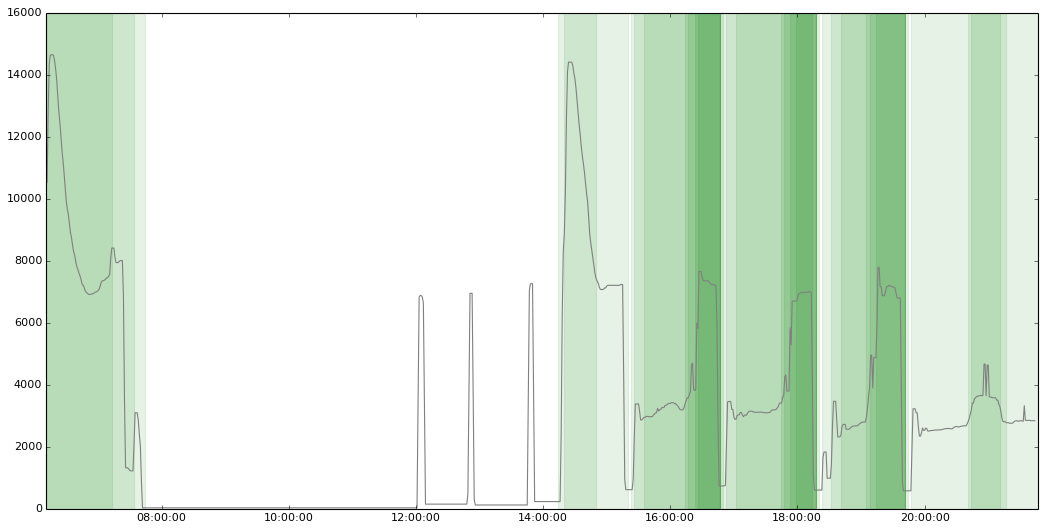

In [181]:
try:
    original_rm, blocks = blockdetection(df_el)
except MyValidationError as exception:
    # handle exception here and get error message
    print exception

In [165]:
dfblocks = [1]
dfblocks=pd.DataFrame(dfblocks,index=[0])
for i in range (1,blocks.index.size):
    dfblocks=dfblocks.append(pd.DataFrame([i], index=[i]))

In [166]:
blocks.index=dfblocks.index

In [167]:
blocks

,start,stop,nested_in
0,2015-12-15 05:21:00+00:00,2015-12-15 07:19:00+00:00,-1.0
1,2015-12-15 05:21:00+00:00,2015-12-15 07:03:00+00:00,0.0
2,2015-12-15 07:03:00+00:00,2015-12-15 07:16:00+00:00,0.0
3,2015-12-15 13:36:00+00:00,2015-12-15 14:04:00+00:00,-1.0
4,2015-12-15 13:39:00+00:00,2015-12-15 13:58:00+00:00,3.0
5,2015-12-15 14:51:00+00:00,2015-12-15 15:04:00+00:00,-1.0
6,2015-12-15 15:39:00+00:00,2015-12-15 15:58:00+00:00,-1.0
7,2015-12-15 15:42:00+00:00,2015-12-15 15:58:00+00:00,6.0
8,2015-12-15 17:06:00+00:00,2015-12-15 17:19:00+00:00,-1.0
9,2015-12-15 17:27:00+00:00,2015-12-15 22:09:00+00:00,-1.0


In [106]:
sensors = hp.get_sensors(sensortype='electricity')

In [ ]:
for i in range(0, len(sensors)):
    key = str(sensors[i]).splitlines()[2][9:]
    electr = hp.find_sensor(str(key))
    df_el = electr.get_data(head,tail,diff=True, unit='W')
    df_el = df_el.dropna()
    
    try:
        original_rm, blocks = blockdetection(df_el)
    except MyValidationError as exception:
        # handle exception here and get error message
        print exception

In [ ]:
blocks